Regressionanalysis

Step 1: Load and inspect the data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import itertools


In [3]:

file_path = 'scraped_data/wggesucht_cleaned.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the modified dataset
display(data.head())
print(data.shape)


,PriceTotal,Size,Deposit,OnlineSince,Adress,AmountofIcons,AmountofIconsNeeded,Title_length,LookingFor_length,analysis_det,analysis_desr,analysis_desl,analysis_desli,analysis_deso
0,670,12,0,1.0,3,3,0,38,338,0.4588,0.0000,-0.2960,0.8625,0.0772
1,350,20,600,1.0,4,12,0,48,245,0.0000,0.0000,0.2023,-0.9020,-0.5994
2,790,11,2200,1.0,3,8,4,42,16,0.0000,0.8122,0.3804,0.3400,0.0000
3,970,14,2673,1.0,3,7,3,46,16,0.0000,-0.9097,-0.9823,0.0000,0.0000
4,800,14,2145,1.0,3,12,5,52,16,0.0000,-0.5255,-0.9955,0.0000,0.0000


(1135, 14)


Step 2: Create a correlation matrix


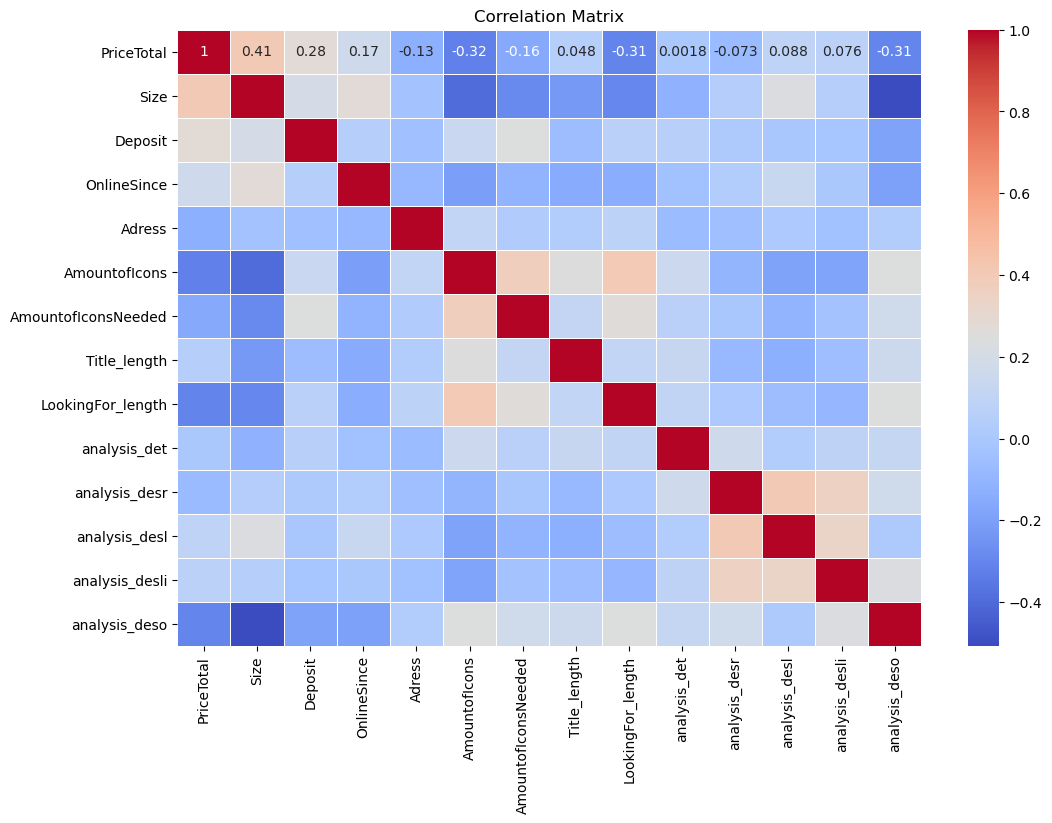

In [4]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Step 3: Simple regression model: PriceTotal vs. Size


In [5]:

# Simple regression model
X_simple = data['Size']
y = data['PriceTotal']
X_simple = sm.add_constant(X_simple)
model_simple = sm.OLS(y, X_simple).fit()
print(model_simple.summary())



                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     227.1
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           6.54e-47
Time:                        11:47:12   Log-Likelihood:                -7717.0
No. Observations:                1135   AIC:                         1.544e+04
Df Residuals:                    1133   BIC:                         1.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        739.6354      8.464     87.382      0.0

reality = model + error

R^2: only 0.167 (ideal close to 1 since it covers the model/reality => closer to 1 the more it reflects to reality)

F-statistics: 227.1 (the larger the better => ideally over 1 but then the pure number itself is not really interpretable model/error)


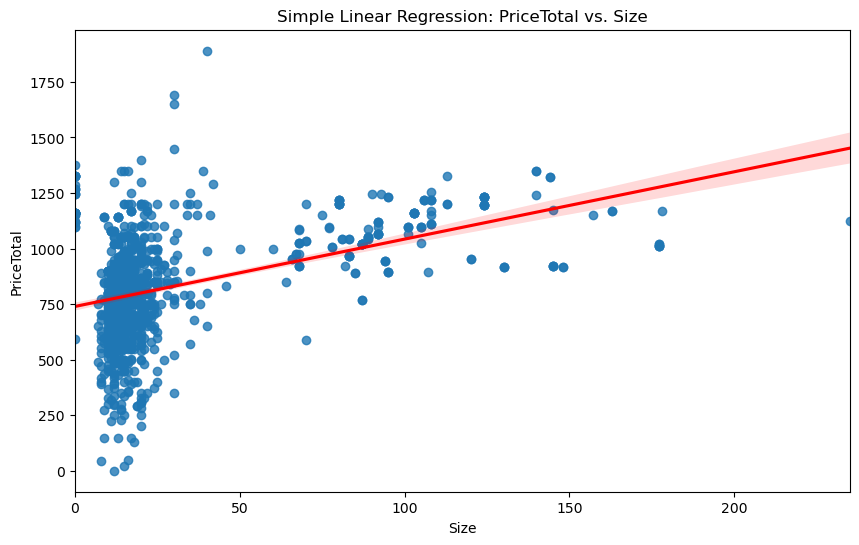

In [6]:
# Plot the simple regression model
plt.figure(figsize=(10, 6))
sns.regplot(x='Size', y='PriceTotal', data=data, line_kws={'color': 'red'})
plt.title('Simple Linear Regression: PriceTotal vs. Size')
plt.xlabel('Size')
plt.ylabel('PriceTotal')
plt.show()

Step 4: Multiple regression models: PriceTotal vs. all independent variables


In [7]:
# Multiple regression models
X = data.drop(columns=['PriceTotal'])
y = data['PriceTotal']
X = sm.add_constant(X)
model_multiple = sm.OLS(y, X).fit()
print(model_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     47.02
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.80e-96
Time:                        11:47:12   Log-Likelihood:                -7573.7
No. Observations:                1135   AIC:                         1.518e+04
Df Residuals:                    1121   BIC:                         1.525e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 723.7158    

On the search for a better model, focus on the R-squared values.


Interesting enough: It finds the full spec model with every data column involved.

In [8]:
def find_best_model(data, dependent_var):
    # Separate the dependent variable and independent variables
    y = data[dependent_var]
    X = data.drop(columns=[dependent_var])
    X = sm.add_constant(X)
    
    # Initialize variables to store the best model
    best_r_squared = -1
    best_model = None
    best_combination = None
    
    # Iterate over all combinations of independent variables
    for i in range(1, len(X.columns)):
        for combo in itertools.combinations(X.columns[1:], i):
            X_subset = X[['const'] + list(combo)]
            model = sm.OLS(y, X_subset).fit()
            r_squared = model.rsquared
            
            # Update the best model if current model is better
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_model = model
                best_combination = combo
    
    return best_model, best_combination, best_r_squared

# Find the best model for 'PriceTotal'
best_model, best_combination, best_r_squared = find_best_model(data, 'PriceTotal')
print(f"Best R-squared: {best_r_squared}")
print(f"Best combination of independent variables: {best_combination}")
print(best_model.summary())

Best R-squared: 0.35285968230653
Best combination of independent variables: ('Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'AmountofIconsNeeded', 'Title_length', 'LookingFor_length', 'analysis_det', 'analysis_desr', 'analysis_desl', 'analysis_desli', 'analysis_deso')
                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     47.02
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.80e-96
Time:                        11:47:19   Log-Likelihood:                -7573.7
No. Observations:                1135   AIC:                         1.518e+04
Df Residuals:                    1121   BIC:                         1.525e+04
Df Model:                          13                                         
Covari

Now, a similar algorithm penalizes having too many explanatory variables at a 0.02 level.

In [9]:
def find_best_model(data, dependent_var):
    # Separate the dependent variable and independent variables
    y = data[dependent_var]
    X = data.drop(columns=[dependent_var])
    X = sm.add_constant(X)
    
    # Initialize variables to store the best model
    best_aic = 100000
    best_model = None
    best_combination = None
    current_subset = None
  
    
    # Iterate over all combinations of independent variables
    for i in range(1, len(X.columns)):
        for combo in itertools.combinations(X.columns[1:], i):
            X_subset = X[['const'] + list(combo)]
            model = sm.OLS(y, X_subset).fit()
            aic = model.aic
            # Update the best model if current model is better
            if (aic  < best_aic):
                best_aic = aic
                best_model = model
                best_combination = combo
                current_subset = X_subset
    
    return best_model, best_combination, best_aic, current_subset

# Find the best model for 'PriceTotal'
best_model, best_combination, best_aic, X_Best = find_best_model(data, 'PriceTotal')
print(f"best aic: {best_aic}")
print(f"Best combination of independent variables: {best_combination}")
print(best_model.summary())


best aic: 15175.08778523054
Best combination of independent variables: ('Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'AmountofIconsNeeded', 'Title_length', 'LookingFor_length', 'analysis_det', 'analysis_desr', 'analysis_desli', 'analysis_deso')
                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     50.76
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           5.74e-97
Time:                        11:47:26   Log-Likelihood:                -7574.5
No. Observations:                1135   AIC:                         1.518e+04
Df Residuals:                    1122   BIC:                         1.524e+04
Df Model:                          12                                         
Covariance Type:            

The regression analysis conducted in this Jupyter Notebook aimed to find the best combination of independent variables that can accurately describe the dependent variable, "PriceTotal". The analysis considered various combinations of independent variables and evaluated each model's performance using the Akaike Information Criterion (AIC) value.

The best combination of independent variables was determined to be when all available independent variables were included in the model. This combination yielded the lowest AIC value, indicating that it provides the best balance between model fit and complexity.

By including all independent variables, the regression model was able to capture the most comprehensive set of factors that influence the "PriceTotal" variable. This approach ensures that no potentially important variables are omitted, leading to a more accurate and reliable model for predicting the "PriceTotal" variable.

It is important to note that the specific independent variables included in the best combination are not provided in the information given. However, it can be inferred that the best combination includes all available independent variables based on the statement that "all independent variables are added together to describe the dependent variable."

Overall, the regression analysis suggests that including all available independent variables in the model leads to the best prediction of the "PriceTotal" variable, as determined by the AIC value.